In [1]:
# Standard stuff
import numpy as np                              #For almost everything
import matplotlib.pyplot as plt                 #For plotting
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pdf import PdfPages       #For saving figures to single pdf
figlist = []

#*******************************************************************************************************
#Setting RC Parameters for figure size and fontsizes
import matplotlib.pylab as pylab                           
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (20, 10),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)
#********************************************************************************************************

# Import pyliso tools
from pyliso import Circuit, save, load
from plotting import plotTF, plotTFs, plotDomASDs
import copy

mList = ['o','v','^','<','>','s','p','*','H','+','X','D']
cList = ['#0072b2','#009e73','#d55e00','#cc79a7','#56b4e9']
cmap = ListedColormap([np.array([0, 114.0/256, 178.0/256, 1]),
                       np.array([0, 158.0/256, 115.0/256, 1]),
                       np.array([213.0/256, 94.0/256, 0, 1]),
                       np.array([204.0/256, 121.0/256, 167.0/256, 1]),
                       np.array([86.0/256, 180.0/256, 233.0/256, 1])])

In [2]:
SN009 = Circuit()
SN009.parseFil('D980454-00.fil')
SN010 = Circuit()
SN010.parseFil('D980454-00.fil')
fflow = 1e6
ffhigh = 1e8
numPoints = 4000
IncPower = 10e-3   # 10mW on the RFPDs

########################
#   Parsing complete   #
########################
()
########################
#   Parsing complete   #
########################
()


## North Cavity Reflection RFPD (SN009)

In [3]:
SN009.removeParts(['R5','L3','C1','C14','R3','C6','C13','L4']) #Remove unpopulated parts
SN009.addResistor('rL3',0.0,'n1','n2')         #0 Ohm jumper instead of L3

SN009.parts['R14'].value=49.9

PeakFreq = 36.036e6
SN009.parts['L2'].value = 81e-9
SN009.parts['L1'].value = 59.1515e-9   #From LTspice simulation

SN009.parts['R1'].value = 681
SN009.parts['R2'].value = 75
SN009.parts['R6'].value = 50

NotchFreq = 73.109e6
SN009.parts['C40'].value = 21.3e-12 - SN009.parts['C39'].value  #There sum is 21.3 pF as measured.
SN009.parts['L8'].value=1/(4*(np.pi**2)*21.3e-12*NotchFreq**2)

SN009.parts['R11'].value = 10
SN009.parts['R16'].value = 1000

ShotNoise = np.sqrt(2*1.6e-19*1.6e-3*0.8)  #pA/rtHz
DarkNoise = 0.03e-12                       #pA/rtHz
PDCurNoise = np.sqrt(ShotNoise**2 + DarkNoise**2)
SN009.parts['PDnoise'].value = 4*1.38064852e-23*300/(PDCurNoise**2)  #Resistance for equivalent current noise

#Disconnect Biasing circuit
SN009.removeParts(['RBias1','RBias2'])
#Reconnect Biasing circuit
#SN009.addResistor('RBias1',0.0,'n10','n10i')
#SN009.addResistor('RBias2',0.0,'n15','n15i')

## South Cavity Reflection RFPD (SN010)

In [4]:
SN010.removeParts(['R5','L3','C1','C14','R3','C6','C13','L4']) #Remove unpopulated parts
SN010.addResistor('rL3',0.0,'n1','n2')         #0 Ohm jumper instead of L3

SN010.parts['R14'].value=49.9

PeakFreq = 36.67e6
SN010.parts['L2'].value =81e-9
SN010.parts['L1'].value = 1/((2*np.pi*PeakFreq)**2)/SN010.parts['PDcj'].value - SN010.parts['L2'].value

SN010.parts['R1'].value = 680
SN010.parts['R2'].value = 75
SN010.parts['R6'].value = 50

NotchFreq = 74.237e6
SN010.parts['C40'].value = 21.3e-12 - SN010.parts['C39'].value  #There sum is 21.3 pF as measured.
SN010.parts['L8'].value=1/(4*(np.pi**2)*21.3e-12*NotchFreq**2)

SN010.parts['R11'].value = 10
SN010.parts['R16'].value = 1000

ShotNoise = np.sqrt(2*1.6e-19*1.6e-3*0.8)  #pA/rtHz
DarkNoise = 0.03e-12                       #pA/rtHz
PDCurNoise = np.sqrt(ShotNoise**2 + DarkNoise**2)
SN010.parts['PDnoise'].value = 4*1.38064852e-23*300/(PDCurNoise**2)  #Resistance for equivalent current noise

#Disconnect Biasing circuit
SN010.removeParts(['RBias1','RBias2'])
#Reconnect Biasing circuit
#SN010.addResistor('RBias1',0.0,'n10','n10i')
#SN010.addResistor('RBias2',0.0,'n15','n15i')

In [6]:
SN009.parts['L1']

L1 is a 4.903967e-08 H inductor

## Transfer function from test ports

In [5]:
SN009.computeTF('nTestIn','nRFout',fflow,ffhigh,numPoints,inNodeVolts=True)
SN010.computeTF('nTestIn','nRFout',fflow,ffhigh,numPoints,inNodeVolts=True)
ff = SN009.ff
plotDict1 = {}
plotDict1['SN009_TestPortTF'] = SN009.TF
plotDict1['SN010_TestPortTF'] = SN010.TF

In [6]:
#SN009.parts['R6'].value=50.0
#SN009.computeTF('nTestIn','nRFout',fflow,ffhigh,numPoints,inNodeVolts=True)
#plotDict1['SN009_TestPortTF_R6=50'] = SN009.TF

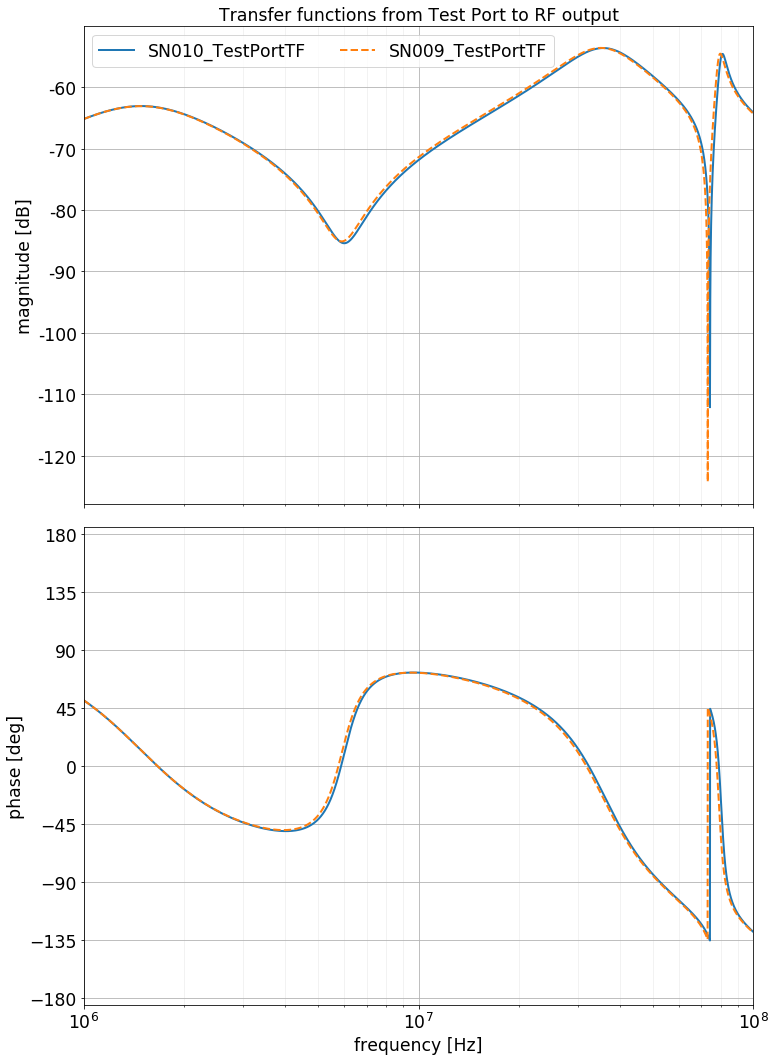

In [9]:
fig1 = plt.figure(figsize=[12,18])
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.05)
mag_ax = fig1.add_subplot(gs[0])
phase_ax = fig1.add_subplot(gs[1], sharex=mag_ax)
plotTFs(ff,plotDict1,mag_ax=mag_ax,phase_ax=phase_ax,linewidth=2,dB=True)
mag_ax.set_title('Transfer functions from Test Port to RF output')
figlist +=[fig1]

## Transfer functions from photocurrent to RF port

In [10]:
plotDict2 = {}
SN009.computeTF('n1','nRFout',fflow,ffhigh,numPoints,inNodeVolts=False)
plotDict2['SN009_PhCuTF'] = SN009.TF
SN010.computeTF('n1','nRFout',fflow,ffhigh,numPoints,inNodeVolts=False)
plotDict2['SN010_PhCuTF'] = SN010.TF

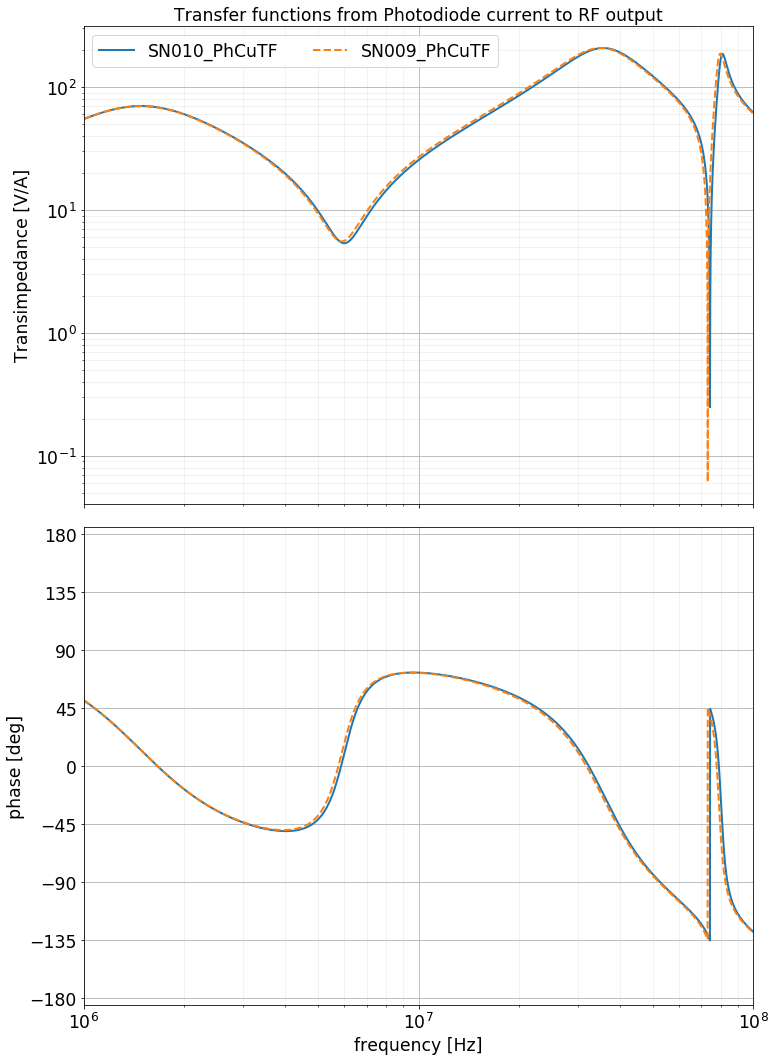

In [11]:
fig2 = plt.figure(figsize=[12,18])
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.05)
mag_ax = fig2.add_subplot(gs[0])
phase_ax = fig2.add_subplot(gs[1], sharex=mag_ax)
plotTFs(ff,plotDict2,mag_ax=mag_ax,phase_ax=phase_ax,linewidth=2)
mag_ax.set_title('Transfer functions from Photodiode current to RF output')
mag_ax.set_ylabel('Transimpedance [V/A]')
figlist +=[fig2]

In [12]:
np.median(abs(plotDict2['SN009_PhCuTF']/plotDict1['SN009_TestPortTF']))

100000.00320645273

## Output voltage noise

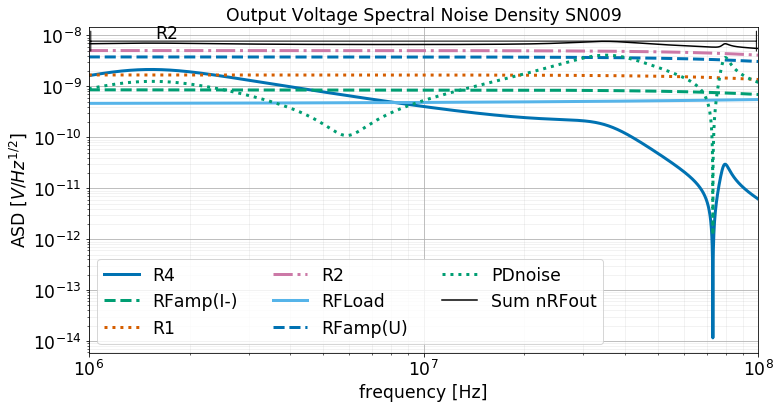

In [13]:
SN009.computeTF('nTestIn','nRFout',fflow,ffhigh,numPoints,inNodeVolts=True)
SN009.computeNoise('nTestIn','nRFout',fflow,ffhigh,numPoints)
SN009.computeAllNoises('nTestIn','nRFout',fflow,ffhigh,numPoints)
tempfig = SN009.plotDomNoises(dB=False, CutoffRank=5, figsize=[12,6], linewidth=3)
tempfig.gca().set_title('Output Voltage Spectral Noise Density SN009')
figlist += [tempfig]

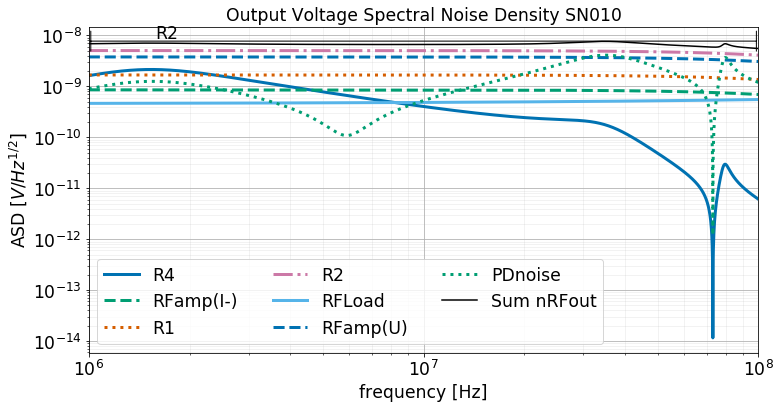

In [14]:
SN010.computeTF('nTestIn','nRFout',fflow,ffhigh,numPoints,inNodeVolts=True)
SN010.computeNoise('nTestIn','nRFout',fflow,ffhigh,numPoints)
SN010.computeAllNoises('nTestIn','nRFout',fflow,ffhigh,numPoints)
tempfig = SN009.plotDomNoises(dB=False, CutoffRank=5, figsize=[12,6], linewidth=3)
tempfig.gca().set_title('Output Voltage Spectral Noise Density SN010')
figlist += [tempfig]

## Input reffered current noise density

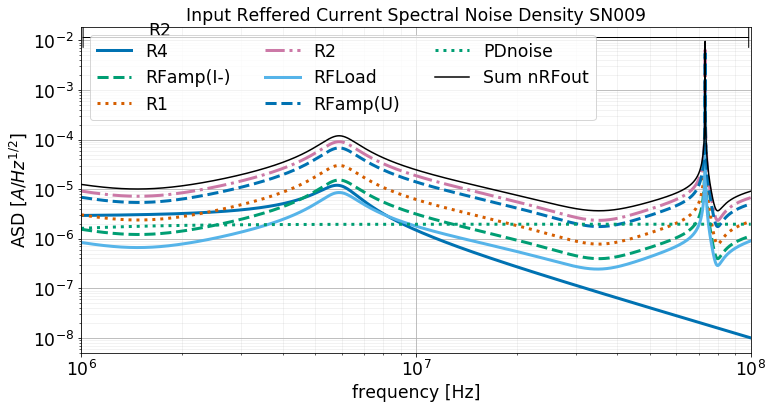

In [15]:
SN009.allInNoiseASDs = SN009.allNoiseASDs
for key,value in SN009.allInNoiseASDs.iteritems():
    SN009.allInNoiseASDs[key] = value/abs(SN009.TF)
SN009.innoiseASD = SN009.noiseASD/abs(SN009.TF)
tempfig = SN009.plotDomInNoises(dB=False, CutoffRank=5, figsize=[12,6], linewidth=3)
tempfig.gca().set_title('Input Reffered Current Spectral Noise Density SN009')
tempfig.gca().set_ylabel(r'ASD [$A/Hz^{1/2}$]')
figlist += [tempfig]

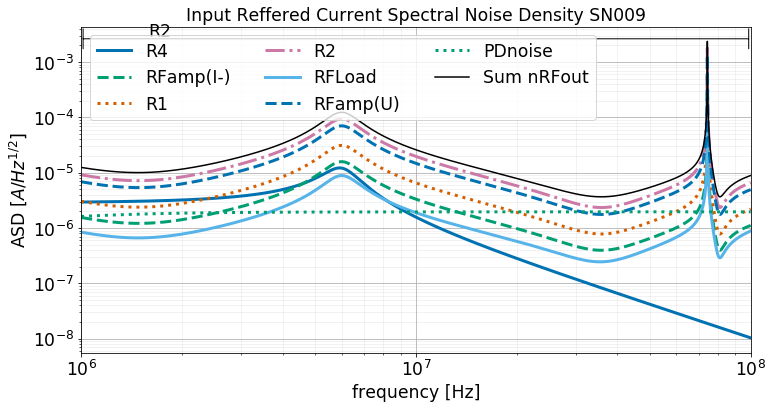

In [16]:
SN010.allInNoiseASDs = SN010.allNoiseASDs
for key,value in SN010.allInNoiseASDs.iteritems():
    SN010.allInNoiseASDs[key] = value/abs(SN010.TF)
SN010.innoiseASD = SN010.noiseASD/abs(SN010.TF)
tempfig = SN010.plotDomInNoises(dB=False, CutoffRank=5, figsize=[12,6], linewidth=3)
tempfig.gca().set_title('Input Reffered Current Spectral Noise Density SN009')
tempfig.gca().set_ylabel(r'ASD [$A/Hz^{1/2}$]')
figlist += [tempfig]

## Breakeven point of Shot-noise to R2 noise with current resistor values

In [17]:
PeakFFind = 3000+np.argmin(SN009.allInNoiseASDs['R2'][3000:3200])
Ratio = SN009.allInNoiseASDs['R2'][PeakFFind]/SN009.allInNoiseASDs['PDnoise'][PeakFFind]
RequiredPower = 1.6e-3*Ratio**2
print('SN009 breakeven point power is '+str(np.round(RequiredPower*1e3,2))+' mW')

SN009 breakeven point power is 2.29 mW


In [18]:
PeakFFind = 3000+np.argmin(SN010.allInNoiseASDs['R2'][3000:3200])
Ratio = SN010.allInNoiseASDs['R2'][PeakFFind]/SN010.allInNoiseASDs['PDnoise'][PeakFFind]
RequiredPower = 1.6e-3*Ratio**2
print('SN010 breakeven point power is '+str(np.round(RequiredPower*1e3,2))+' mW')

SN010 breakeven point power is 2.29 mW


## If R2 is changed to 51 Ohm

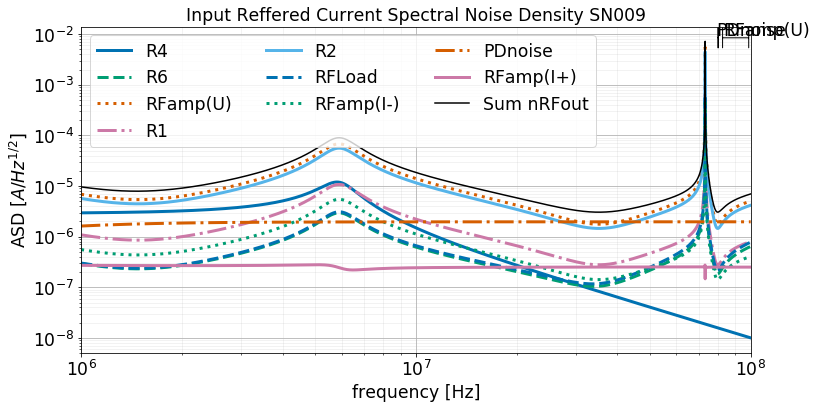

In [19]:
SN009.parts['R2'].value = 25.0
SN009.parts['R1'].value = 681
SN009.computeTF('nTestIn','nRFout',fflow,ffhigh,numPoints,inNodeVolts=True)
SN009.computeNoise('nTestIn','nRFout',fflow,ffhigh,numPoints)
SN009.computeAllNoises('nTestIn','nRFout',fflow,ffhigh,numPoints)
SN009.allInNoiseASDs = SN009.allNoiseASDs
for key,value in SN009.allInNoiseASDs.iteritems():
    SN009.allInNoiseASDs[key] = value/abs(SN009.TF)
SN009.innoiseASD = SN009.noiseASD/abs(SN009.TF)
tempfig = SN009.plotDomInNoises(dB=False, CutoffRank=5, figsize=[12,6], linewidth=3)
tempfig.gca().set_title('Input Reffered Current Spectral Noise Density SN009')
tempfig.gca().set_ylabel(r'ASD [$A/Hz^{1/2}$]')
figlist += [tempfig]

In [20]:
PeakFFind = 3000+np.argmin(SN009.allInNoiseASDs['R2'][3000:3200])
Ratio = SN009.allInNoiseASDs['R2'][PeakFFind]/SN009.allInNoiseASDs['PDnoise'][PeakFFind]
RequiredPower = 1.6e-3*Ratio**2
print('SN009 breakeven point power is '+str(np.round(RequiredPower*1e3,2))+' mW')
TIbeforeRFamp = np.abs(SN009.TF[PeakFFind])*1e5*SN009.parts['R2'].value/SN009.parts['R1'].value
OpPower=2.5e-3
beta=0.3
Vpatn3 = 2*beta*OpPower*0.75*TIbeforeRFamp
CurrOut = Vpatn3/SN009.parts['R2'].value + Vpatn3*(SN009.parts['R1'].value/SN009.parts['R2'].value +1)/(50.0+SN009.parts['R6'].value)
print('Required current output at Operating power of '+str(np.round(OpPower*1e3,2))+' mW is '+str(np.round(CurrOut*1e3,2))+' mA')

SN009 breakeven point power is 0.88 mW
Required current output at Operating power of 2.5 mW is 5.75 mA


In [21]:
SN009.parts['R6']

R6 is a 5.000000e+01 Ohm resistor

In [27]:
SN009.parts['R1'].value=681.0
OpPower=2.5e-3
beta=0.3
breakevenpts = np.zeros(75)
CurrOutput = np.zeros(75)
TIatpeak = np.zeros(75)
TIbefRFamp = np.zeros(75)
ii=0
for R2 in range(1,76,1):
    SN009.parts['R2'].value = float(R2)
    SN009.computeTF('nTestIn','nRFout',fflow,ffhigh,numPoints,inNodeVolts=True)
    SN009.computeNoise('nTestIn','nRFout',fflow,ffhigh,numPoints)
    SN009.computeAllNoises('nTestIn','nRFout',fflow,ffhigh,numPoints)
    SN009.allInNoiseASDs = SN009.allNoiseASDs
    for key,value in SN009.allInNoiseASDs.iteritems():
        SN009.allInNoiseASDs[key] = value/abs(SN009.TF)
    PeakFFind = 3000+np.argmin(SN009.allInNoiseASDs['R2'][3000:3200])
    Ratio = SN009.allInNoiseASDs['R2'][PeakFFind]/SN009.allInNoiseASDs['PDnoise'][PeakFFind]
    TIatpeak[ii] = np.max(np.abs(SN009.TF))*1e6
    breakevenpts[ii] = 1.6e-3*Ratio**2
    TIbefRFamp[ii] = TIatpeak[ii]*SN009.parts['R2'].value/SN009.parts['R1'].value
    Vpatn3 = 2*beta*OpPower*0.75*TIbefRFamp[ii]
    CurrOutput[ii] = Vpatn3/SN009.parts['R2'].value + Vpatn3*(SN009.parts['R1'].value/SN009.parts['R2'].value +1)/(50.0+SN009.parts['R6'].value)
    ii=ii+1

In [28]:
np.max(np.abs(SN009.TF))

0.0020847742632813596

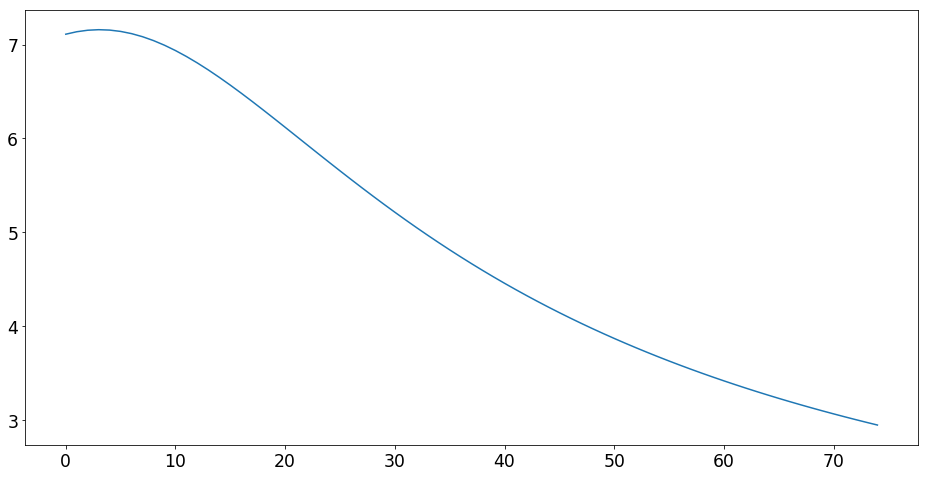

In [29]:
figTrend = plt.figure(figsize=[16,8])
plt.plot(CurrOutput*1e3)

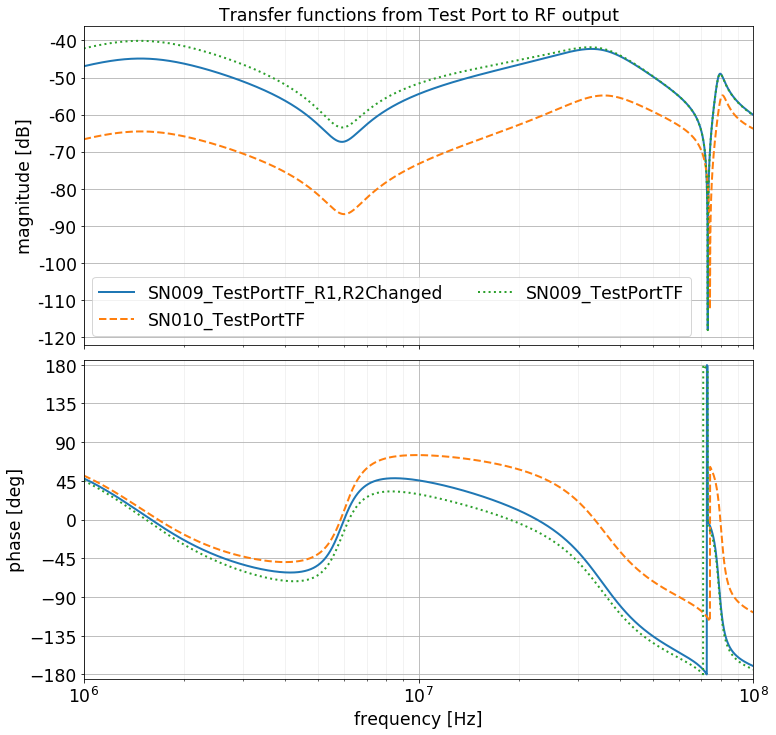

In [19]:
plotDict1['SN009_TestPortTF_R1,R2Changed'] = SN009.TF
fig1 = plt.figure(figsize=[12,12])
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.05)
mag_ax = fig1.add_subplot(gs[0])
phase_ax = fig1.add_subplot(gs[1], sharex=mag_ax)
plotTFs(ff,plotDict1,mag_ax=mag_ax,phase_ax=phase_ax,linewidth=2,dB=True)
mag_ax.set_title('Transfer functions from Test Port to RF output')
figlist +=[fig1]

In [20]:
beta=0.3
TIbeforeRFamp=250
Vpatn3 = 2*beta*1e-3*0.8*TIbeforeRFamp
CurrOut = Vpatn3/SN009.parts['R2'].value + Vpatn3*(SN009.parts['R1'].value/SN009.parts['R2'].value +1)/100.0
print('Required current output '+str(np.round(CurrOut*1e3,2))+' mA')

Required current output 79.3 mA
